# Моделирование процесса восстановления золота из руды

Необходимо подготовить прототип модели машинного обучения для компании, разрабатывающей решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Будем использовать данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Цель:** смоделировать процесс восстановления золота из золотосодержащей руды.

**Задачи**:

1. Подготовить данные
2. Провести исследовательский анализ данных
3. Построить и обучить модель

In [1]:
import pandas as pd
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

In [2]:
# функция для определения эффективности обогащения

def recovery(data):
    C = data['rougher.output.concentrate_au']
    F = data['rougher.input.feed_au']
    T = data['rougher.output.tail_au']
    return ((C*(F-T))/(F*(C-T)))*100

In [3]:
# функция для наглядного представления того, как в среднем меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

def concentrate_plotting(data, metal_name: str):
    start_point_name = 'rougher.input.feed_' + metal_name
    rougher_name = 'rougher.output.concentrate_' + metal_name
    primary_clean_name = 'primary_cleaner.output.concentrate_' + metal_name
    secondary_clean_name = 'final.output.concentrate_' + metal_name
    
    start_point = data[start_point_name].mean()
    rougher = data[rougher_name].mean()
    primary_cleaner = data[primary_clean_name].mean()
    secondary_cleaner = data[secondary_clean_name].mean() 
    
    df = pd.DataFrame([start_point, rougher, primary_cleaner, secondary_cleaner], columns=['mean'], index = [start_point_name, rougher_name, primary_clean_name, secondary_clean_name])
    
    return sns.barplot(x = df.index, y = df['mean'], data=df, ax=ax)

In [4]:
# функция для наглядного представления того, как меняется распределение концентрации металлов (Au, Ag, Pb) на различных этапах очистки

def concentrate_distributions(data, metal_name: str, color: str):
    
    start_point_name = 'rougher.input.feed_' + metal_name
    rougher_name = 'rougher.output.concentrate_' + metal_name
    primary_clean_name = 'primary_cleaner.output.concentrate_' + metal_name
    secondary_clean_name = 'final.output.concentrate_' + metal_name
    
    col_names = [start_point_name, rougher_name, primary_clean_name, secondary_clean_name]
    _, axs = plt.subplots(2, 2, figsize=(15,10))
    axs = axs.ravel()    
    
    for i in range(len(col_names)):
        ax = axs[i]
        sns.histplot(ax=ax, x=df_full[col_names[i]], color=color)
        ax.tick_params(axis='x')
        ax.set_title(metal_name.capitalize() + ' ' + col_names[i])

In [5]:
# функция для получения уникальной даты эксперимента (понадобится для удаления аномалий)

date = []
def date_picker(rows):
    rougher_output = rows['rougher.output.sum']
    final_output = rows['final.output.sum']
    
    if (rougher_output == 0) or (final_output == 0):
        return date.append(rows['date'])

In [6]:
# функция для оценки качества моделей Symmetric Mean Absolute Percentage Error

def smape(y_true, y_pred):
    error = np.abs(y_true - y_pred)
    scale = (np.abs(y_true) + np.abs(y_pred))/2
    return np.mean(error/scale)*100

In [7]:
# функция для расчёта итоговой метрики

def final_smape(rougher, final):
    return 0.25*rougher + 0.75*final

## Подготовка данных

Откроем файлы и изучим их. Все переменные в массиве данных вещественные, за исключением строковой переменной `date` – уникальная дата эксперимента (наблюдения).

In [8]:
try:
    df_full = pd.read_csv('/Users/anshilina/Downloads/gold_recovery_full_new.csv')
    df_train = pd.read_csv('/Users/anshilina/Downloads/gold_recovery_train_new.csv')    
    df_test = pd.read_csv('/Users/anshilina/Downloads/gold_recovery_test_new.csv')
except:
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')    
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [9]:
display.display(df_full.head(3))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [10]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Изучим распределение целевых переменных: `rougher.output.recovery` и `final.output.recovery`. Распредления имеют вид нормального, смещенного вправо (с левым тяжелым хвостом).

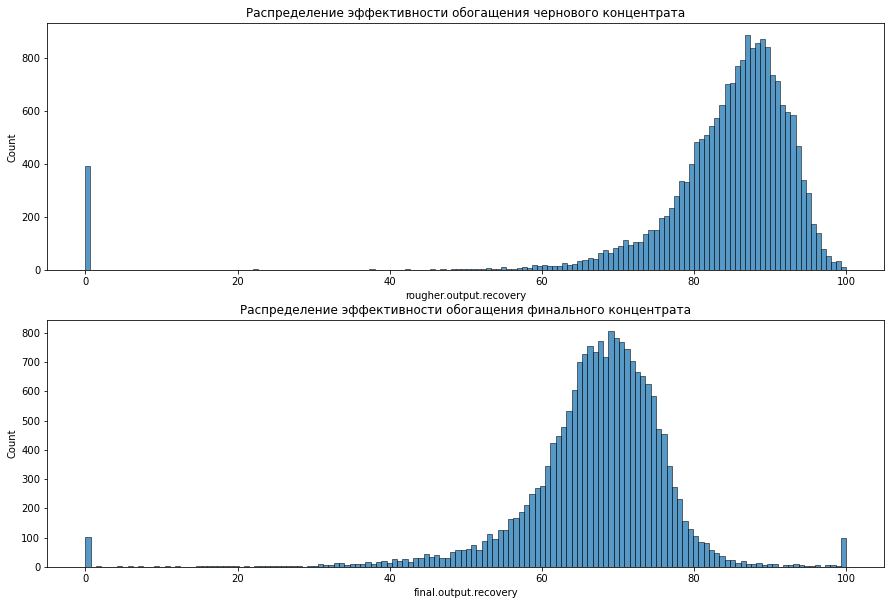

In [11]:
col_names = ['rougher.output.recovery', 'final.output.recovery']
col_titles = ['Распределение эффективности обогащения чернового концентрата', 
              'Распределение эффективности обогащения финального концентрата']

_, axs = plt.subplots(2, 1, figsize=(15,10))
axs = axs.ravel()

for i in range(len(col_names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df_full[col_names[i]])
    ax.tick_params(axis='x')
    ax.set_title(col_titles[i])
    

Изучим признаки. Стоит обратить внимание, что у многих признаков различный масштаб (шкала измерения). На качестве решающих деревьев и случайного леса это не скажется, но для линейной регрессии необходимо будет масштабировать признаки.

In [12]:
df_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака `rougher.output.recovery`. Найдем MAE между нашими расчётами и значением признака.

Эффективность обогащения рассчитывается по формуле: (C*(F-T))/(F*(C-T)), где:

* C — доля золота в концентрате после флотации/очистки, переменная `rougher.output.concentrate_au`
* F — доля золота в сырье/концентрате до флотации/очистки, переменная `rougher.input.feed_au`
* T — доля золота в отвальных хвостах после флотации/очистки, переменная `rougher.output.tail_au`

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат. Для рассчёта воспользуемся функцией `recovery`. После визуализируем распределения.

In [13]:
df_recovery = pd.DataFrame(recovery(df_train), columns=['recovery_calc']) # используем функцию
df_recovery['recovery_true'] = df_train['rougher.output.recovery']
display.display(df_recovery.head())
print('MAE между нашими расчётами и значением признака:', 
      round(mean_absolute_error(df_recovery['recovery_true'], df_recovery['recovery_calc']), 5))

,recovery_calc,recovery_true
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


MAE между нашими расчётами и значением признака: 0.0


Теперь проанализируем признаки, недоступные в тестовой выборке. В тестовой выборке отсутсвуют целевые признаки – `rougher.output.recovery` и `final.output.recovery`(эффективность обогащения чернового и финального концентрата соответственно). Мы оставим их в тренировочной выборке, поскольку они понадобятся для обучения модели. 

Все остальные параметры, которые доступны в тренировочной выборке, но недоступны в тесте – это наблюдения, полученные уже после запуска процесса. Другими словами, это либо параметры полученного продукта (`output`) на одном из этапов очистки (концентрат и отвальные хвосты после флотации, первичной и вторичной очистки), либо расчётные характеристики (`calculation`) на этапе флотации: соотношение сульфида натрия к золоту в концентрате, соотношение оотношение сульфида натрия к золоту в сырье в 10 и 11 флотационной установке, соотношение золота к свинцу. 

**Вывод:** Поскольку это параметры, которые **наблюдаются не на этапе принятия решения**, а уже после того как процесс был запущен, не стоит использовать их для обучения модели – в противном случае возникнет проблема подглядывания в данные. Поэтому мы удалим их из обучающей выборки перед тем, как обучить модель.

In [14]:
different_vars = [var for var in df_train.columns if var not in df_test.columns]
different_vars

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Предобработаем данные: изучим пропуски и дубликаты, избавимся от них при необходимости.

In [15]:
print('Кол-во дубликатов:', df_full.duplicated().sum())
print('Размеры массива данных:', df_full.shape)
print('Кол-во пропусков', df_full.isna().sum().sum())

Кол-во дубликатов: 0
Размеры массива данных: (19439, 87)
Кол-во пропусков 4481


Посмотрим на переменные с самым большим количеством пропусков.

In [16]:
df_na = pd.DataFrame(df_full.isna().sum(), columns=['sum_na']).sort_values(by='sum_na', ascending=False)
df_na = df_na.query('sum_na > 0')
display.display(df_na.head(25))

,sum_na
secondary_cleaner.output.tail_sol,1748
rougher.input.floatbank11_xanthate,453
rougher.state.floatbank10_e_air,436
primary_cleaner.output.concentrate_sol,370
secondary_cleaner.state.floatbank2_a_air,220
final.output.concentrate_sol,211
rougher.input.feed_size,145
primary_cleaner.output.concentrate_pb,116
primary_cleaner.input.xanthate,104
final.output.tail_pb,101


Поскольку соседние по времени параметры часто похожи можно заполнить пропущенные значения либо предыдущими в столбце (метод `bfill`), либо последующими (метод `ffill`). В данном случае мы заполняем пропуски в полном массиве данных и на тренировочной выборке каждым последующим значением. Пропуски в тестовой выбоке мы не будем заполнять, а перед проверкой на тесте удалим их методом `dropna`. Так мы минимизируем наше влияние на тестовые данные.

In [17]:
df_full = df_full.fillna(method='ffill').copy()
df_train = df_train.fillna(method='ffill').copy()

print(df_full.isna().sum().sum())
print(df_train.isna().sum().sum())

0
0


Мы также можем наблюдать в данных высокую мультиколинеарность. Схожите по типу и взаимосвязанные процессы сильно скореллированы – это нормально и естественно. Мультиколлинеарность не должна отразиться на качестве решающих деревьев, но может сильно исказить результаты линейной регрессии. Поэтому в исследовании была предпринята попытка удалить некоторые из сильно скореллированных признаков. Это не помогло улучшить качество моделей (в некоторых случаях оно стало хуже). Этот этап был опущен в проекте, поскольку не несет содержательной ценности. 

In [18]:
df_corr = df_full.corr().abs().unstack().drop_duplicates()
df_corr[(df_corr > 0.7) & (df_corr != 1)].sort_values(ascending=False)

rougher.state.floatbank10_b_level                   rougher.state.floatbank10_c_level                     0.987836
rougher.state.floatbank10_e_level                   rougher.state.floatbank10_f_level                     0.980917
rougher.state.floatbank10_c_level                   rougher.state.floatbank10_d_level                     0.980911
rougher.state.floatbank10_b_level                   rougher.state.floatbank10_d_level                     0.971205
rougher.calculation.floatbank10_sulfate_to_au_feed  rougher.calculation.floatbank11_sulfate_to_au_feed    0.965838
rougher.state.floatbank10_c_level                   rougher.state.floatbank10_e_level                     0.962116
primary_cleaner.state.floatbank8_a_air              primary_cleaner.state.floatbank8_b_air                0.953132
rougher.state.floatbank10_c_level                   rougher.state.floatbank10_f_level                     0.952531
rougher.state.floatbank10_b_level                   rougher.state.floatbank10_e_

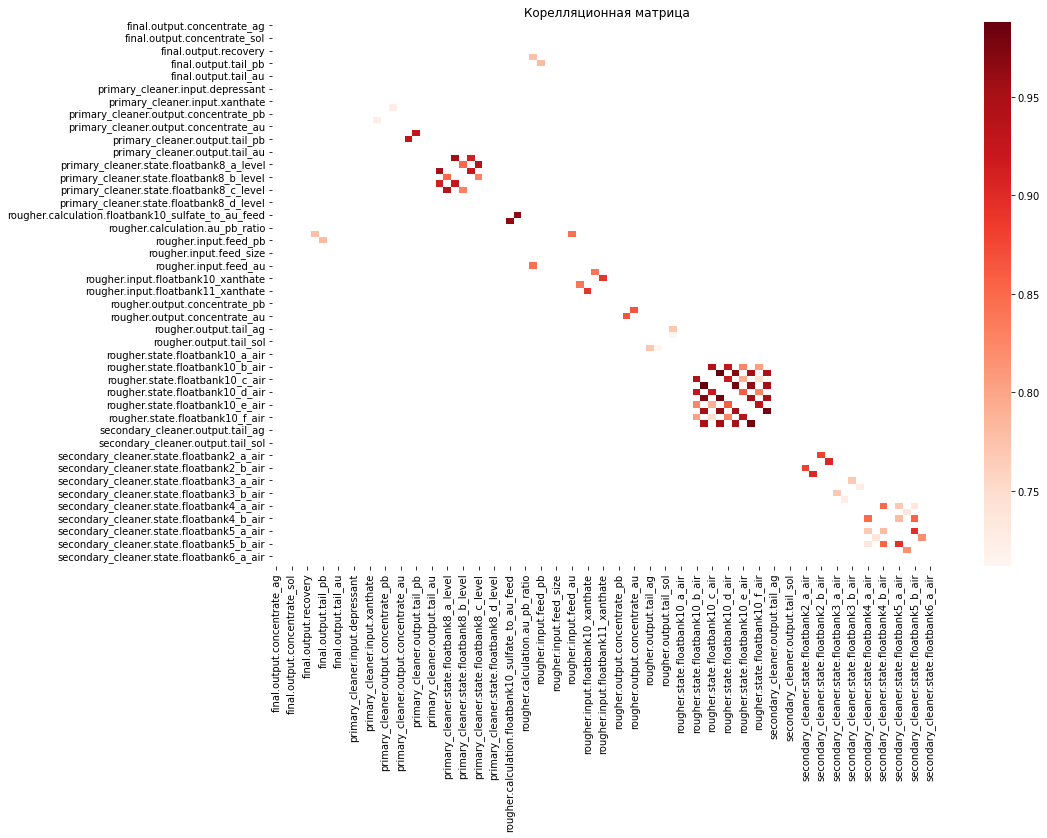

In [19]:
df_corr = df_full.corr().abs()
filteredDf = df_corr[(df_corr >= .7) & (df_corr !=1.000)]
plt.figure(figsize=(15,10))
sns.heatmap(filteredDf, cmap="Reds")
plt.title('Корелляционная матрица')
plt.show()

## Исследовательский анализ данных

Изучим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Для начала рассмотрим, как концентрация каждого метала в среднем изменяется на каждом этапе. Мы видим, что концентрация золота и свинца растет, а концентрация серебра сокращается.

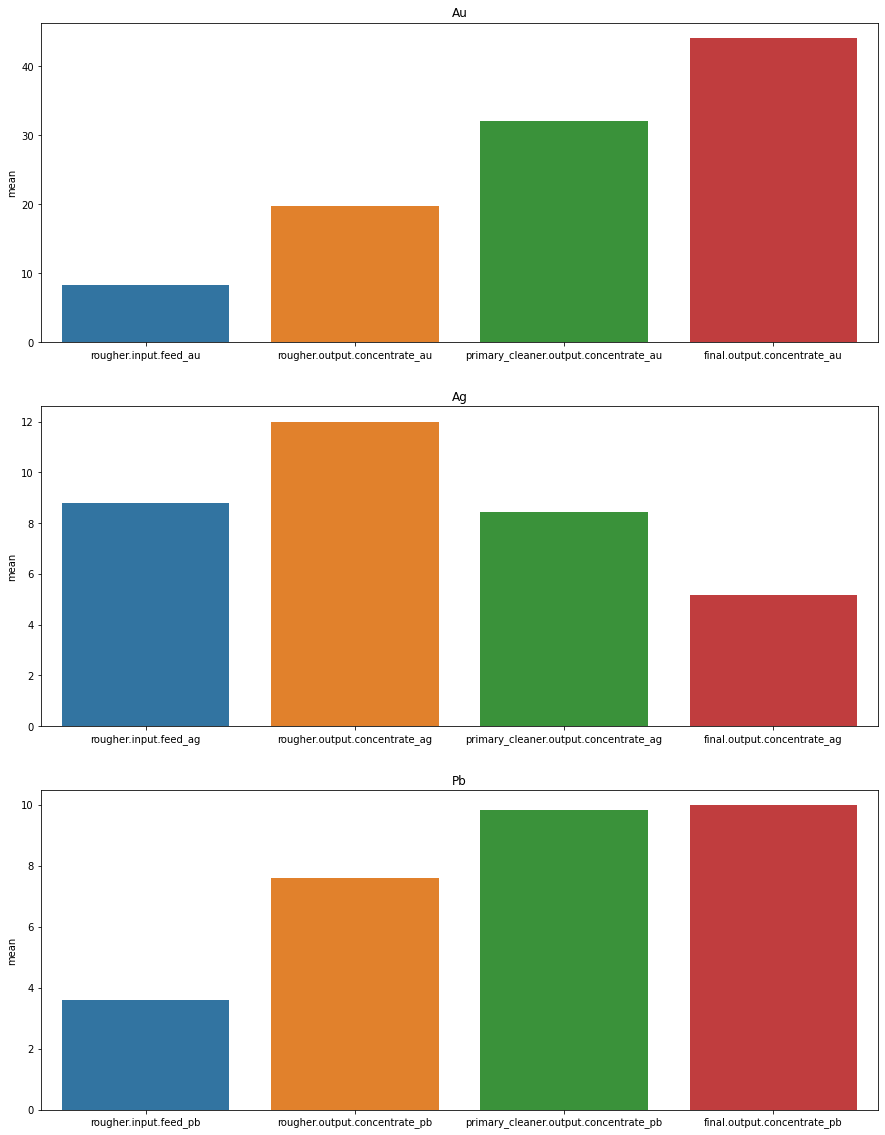

In [20]:
metal_name = ['au', 'ag', 'pb']
_, axs = plt.subplots(3, 1, figsize=(15,20))
axs = axs.ravel()

for i in range(len(metal_name)):
    ax = axs[i]
    concentrate_plotting(df_full, metal_name[i])
    ax.tick_params(axis='x')
    ax.set_title(metal_name[i].capitalize())

Далее посмотрим на распределение концентрации металлов (Au, Ag, Pb) на различных этапах очистки. Первый график – распределение сырья, второй-четвертый график – распределение металлов на каждом этапе очистки. Для каждого из трёх металов мы можем наблюдать выбросы в нуле.

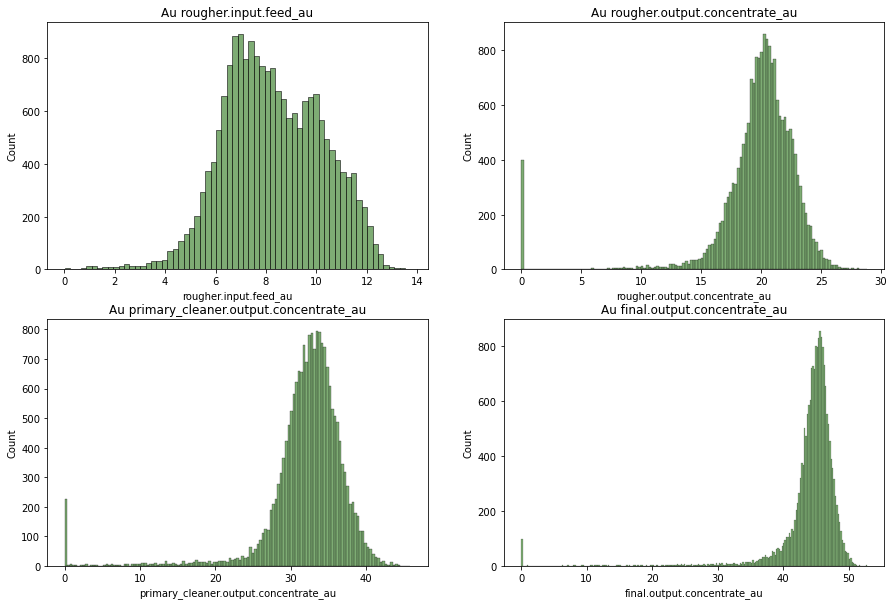

In [21]:
concentrate_distributions(df_full, 'au', '#539045')
plt.show()

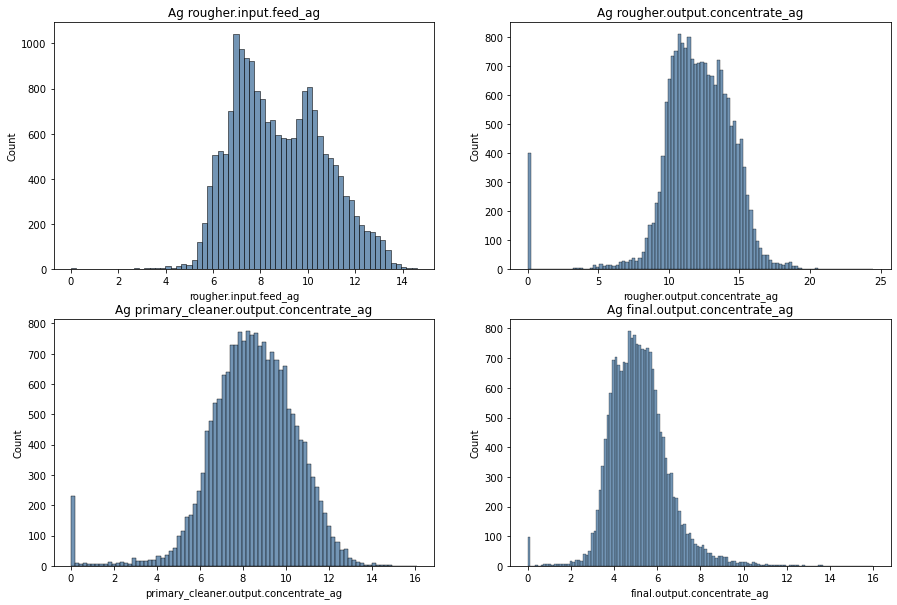

In [22]:
concentrate_distributions(df_full, 'ag', '#44729d')
plt.show()

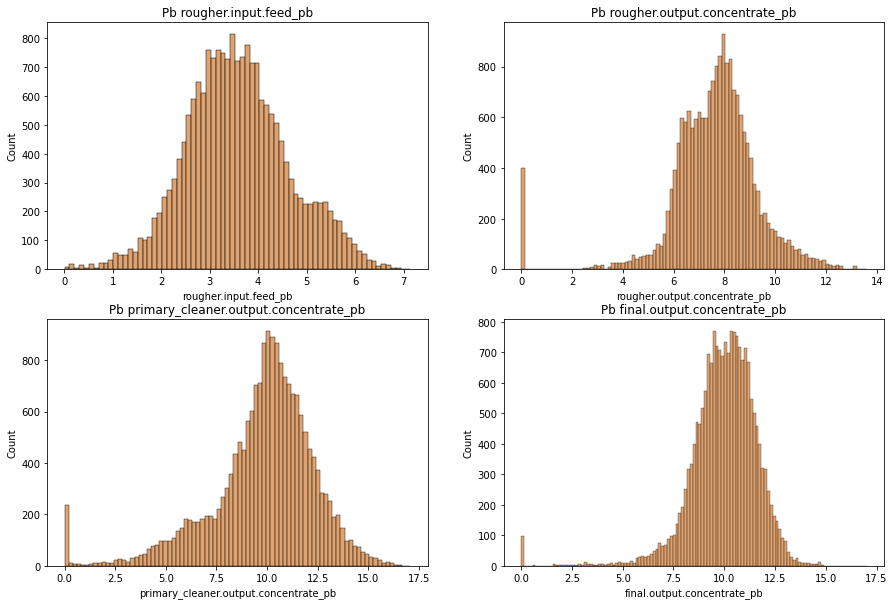

In [23]:
concentrate_distributions(df_full, 'pb', '#d48540')
plt.show()

**Выводы:** Эти аномалии могут повлиять на качество модели. Было принято решение обратить на них внимание и при необходимости исключить из обучающей выборки.

Теперь сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной. Поскольку выборки для обучения и теста разного размера, поэтому нужна нормализация по плотности – будем использовать параметр `stat='density'`.

На этапе флотации распределения похожи – они смещены влево с тяжёлым правым хвостом. 

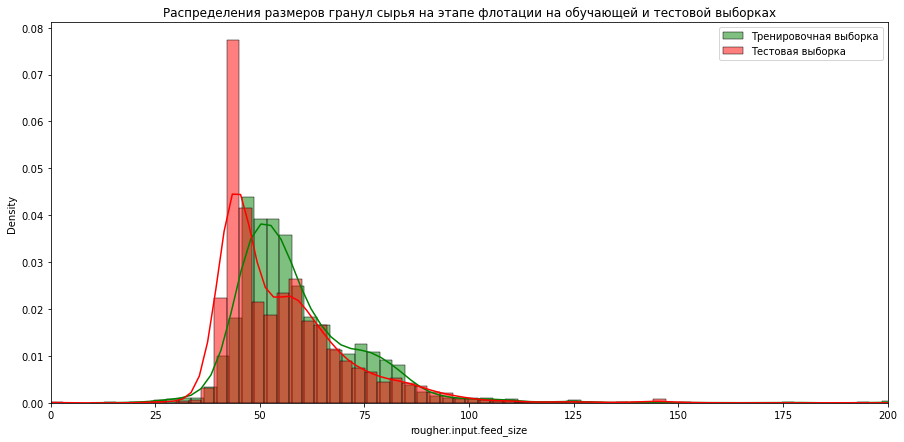

In [24]:
plt.figure(figsize=(15,7))
sns.histplot(x=df_train['rougher.input.feed_size'], binwidth=3, kde=True, color='green', stat='density', label='Тренировочная выборка')
sns.histplot(x=df_test['rougher.input.feed_size'], binwidth=3, kde=True, color='red', stat='density', label='Тестовая выборка')
plt.xlim(0,200)
plt.title('Распределения размеров гранул сырья на этапе флотации на обучающей и тестовой выборках')
plt.legend()
plt.show()

Далее сравним распределения на этапе первичной обработки. Они одинаковые, напоминают нормальное распределение со средним, расположенным от 7 до 8.

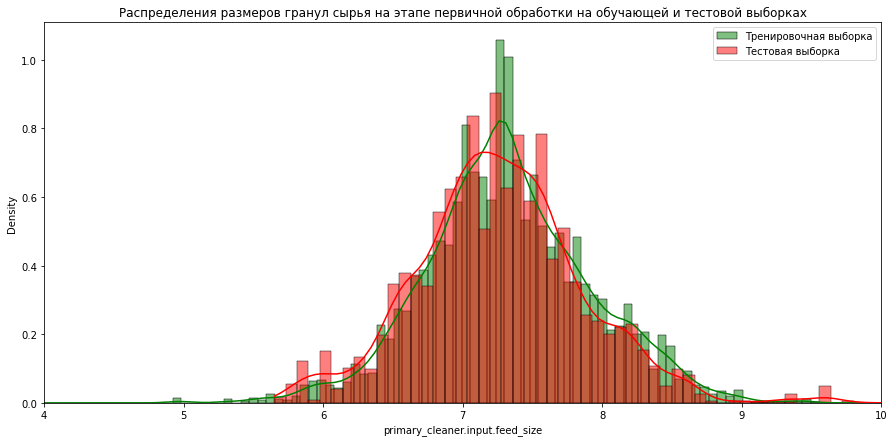

In [25]:
plt.figure(figsize=(15,7))
sns.histplot(x=df_train['primary_cleaner.input.feed_size'], kde=True, color='green', stat='density', label='Тренировочная выборка')
sns.histplot(x=df_test['primary_cleaner.input.feed_size'], kde=True, color='red', stat='density', label='Тестовая выборка')
plt.xlim(4,10)
plt.title('Распределения размеров гранул сырья на этапе первичной обработки на обучающей и тестовой выборках')
plt.legend()
plt.show()

Наконец, исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Каждая строчка – это один из множества экспериментов (попыток) получить золото. Мы для каждого наблюдения вычисляем по три показателя (для каждого из трёх этапов). Каждый показатель – суммарное значение для трех металлов на одном из этапов. Далее мы строим распределение по всем экспериментам (наблюдениям).

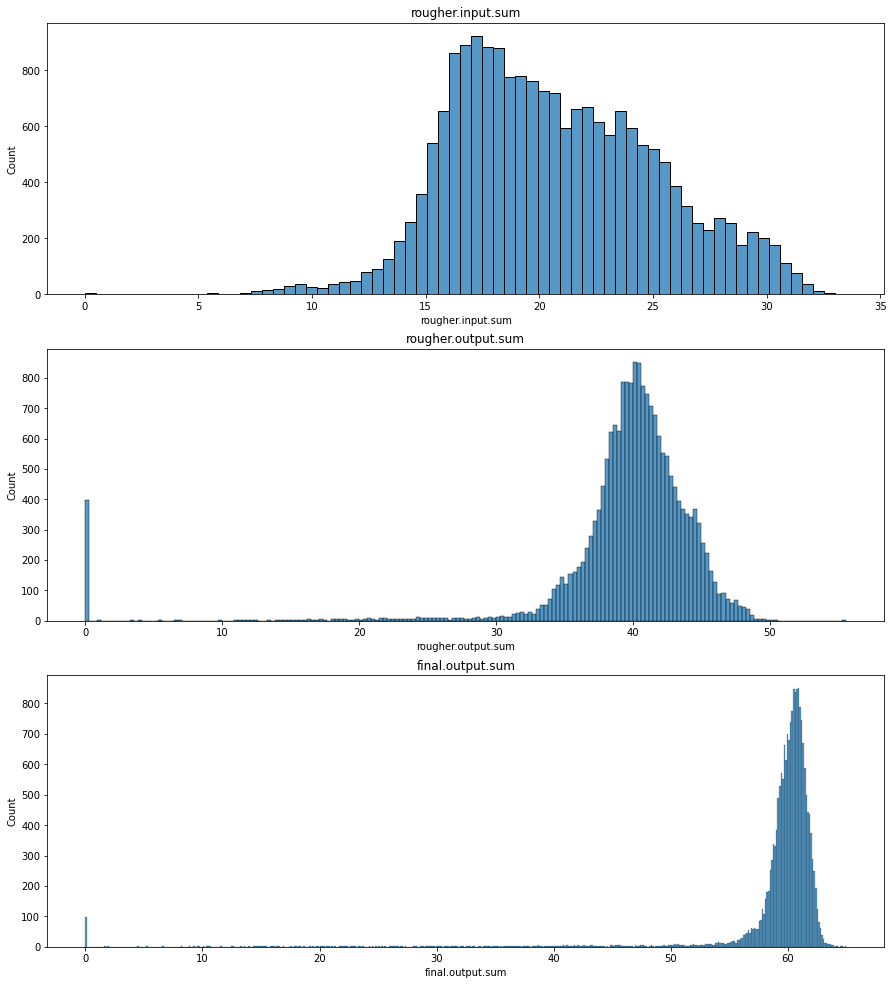

In [26]:
df_full['rougher.input.sum'] = sum([df_full['rougher.input.feed_ag'], df_full['rougher.input.feed_au'], df_full['rougher.input.feed_pb']])
df_full['rougher.output.sum'] = sum([df_full['rougher.output.concentrate_ag'], df_full['rougher.output.concentrate_au'], df_full['rougher.output.concentrate_pb']])
df_full['final.output.sum'] = sum([df_full['final.output.concentrate_ag'], df_full['final.output.concentrate_au'], df_full['final.output.concentrate_pb']])

stage_names = ['rougher.input.sum', 'rougher.output.sum', 'final.output.sum']
_, axs = plt.subplots(3, 1, figsize=(15,17))
axs = axs.ravel()    

for i in range(len(stage_names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df_full[stage_names[i]])
    ax.tick_params(axis='x')
    ax.set_title(stage_names[i])

**Вывод:** Мы наблюдаем аномалии в нуле для суммарной концентрации всех веществ в черновом и финальном концентратах. Их стоит удалить из обучающей выборки. Для этого мы получим уникальные значения даты и времени, когда были зафиксированы нулевые суммы, и будем использлвать их для удаления аномалий из тренировочной выборки. 

В тестовой выборке предлагается оставить наблюдения с нулевой суммой: мы не будем подгонять данные под идеальную выборку. Поскольку тест – это условно реальные данные, которые мы можем получить в ходе экспериментов, оставим аномалии и посмотрим, как с этим справится наша модель.

In [27]:
# используем функцию для получения уникальной даты эксперимента, в котором наблюдаются аномалии
df_full.apply(date_picker, axis=1)
# date – список, который создается для сохранения даты при запуске функции в самом начале
date[:5]

['2016-01-16 21:00:00',
 '2016-01-16 22:00:00',
 '2016-01-16 23:00:00',
 '2016-01-17 00:00:00',
 '2016-01-17 02:00:00']

In [28]:
print(df_full.shape)
print(df_train.shape)

df_full = df_full.query('date not in @date').copy()
print(df_full.shape)

df_train = df_train.query('date not in @date').copy()
print(df_train.shape)

(19439, 90)
(14149, 87)
(18949, 90)
(13795, 87)


Проверим, удалились ли аномалии из обучающей выборки.

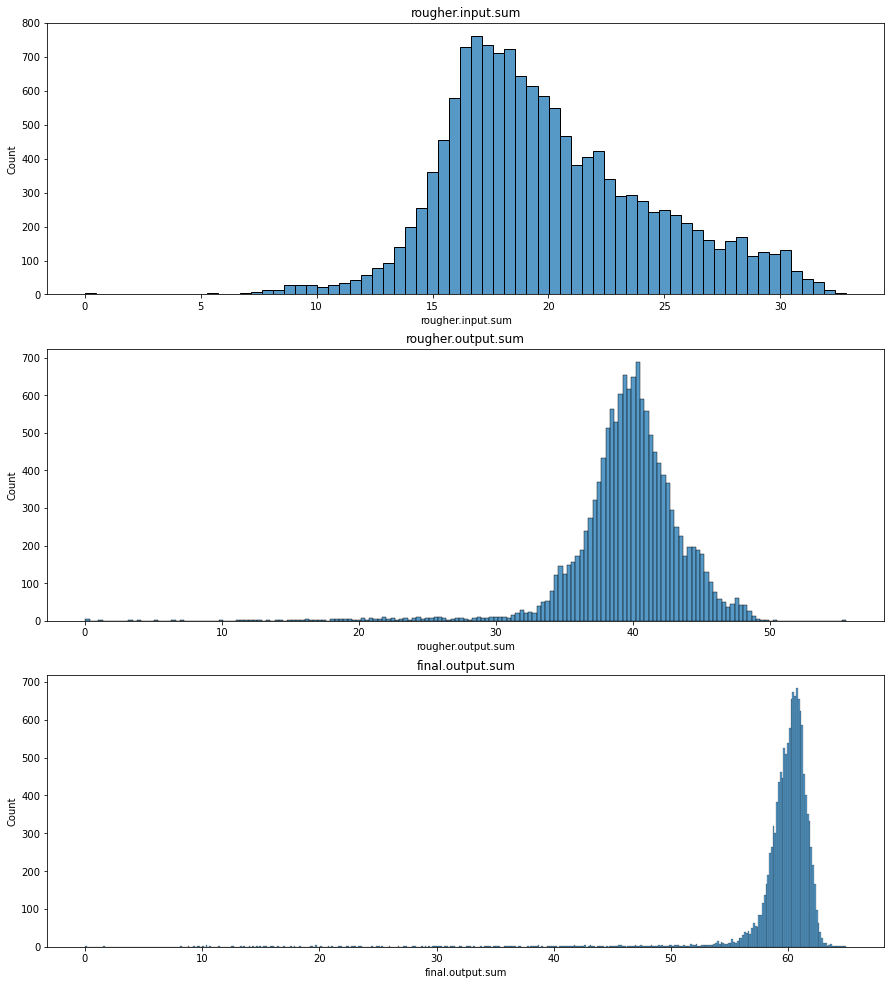

In [29]:
df_train['rougher.input.sum'] = sum([df_train['rougher.input.feed_ag'], df_train['rougher.input.feed_au'], df_train['rougher.input.feed_pb']])
df_train['rougher.output.sum'] = sum([df_train['rougher.output.concentrate_ag'], df_train['rougher.output.concentrate_au'], df_train['rougher.output.concentrate_pb']])
df_train['final.output.sum'] = sum([df_train['final.output.concentrate_ag'], df_train['final.output.concentrate_au'], df_train['final.output.concentrate_pb']])

stage_names = ['rougher.input.sum', 'rougher.output.sum', 'final.output.sum']
_, axs = plt.subplots(3, 1, figsize=(15,17))
axs = axs.ravel()    

for i in range(len(stage_names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df_train[stage_names[i]])
    ax.tick_params(axis='x')
    ax.set_title(stage_names[i])

**Вывод:** Мы выявили аномалии, проанализировали их и удалили из обучающей выборки. В тесте было принято решение оставить эти данные. Мы также проанализировали распределения некоторых переменных (распределения размеров гранул сырья), убедились в том, что они одинаковые на обучающей и тестовой выборках.

## Модели для предсказания эффективности обогащения чернового и финального концентрата

Далее мы обучим разные модели и оценим их качество кросс-валидацией. Для кросс-валидации будет использоваться GridSearchCV. Для каждого таргета будет выбрана своя лучшая модель, которая будет проверена на тестовой выборке.

Для начала удалим из тренировочного датафрейма отсутствующие в тестовом признаки (кроме целевых), поскольку **эти данные нам недоступны на момент принятия решения.**

In [30]:
print(df_train.shape)

# формируем массив данных to_drop, где будет храниться информация о том, какие переменные необходимо удалить из трейна
# удаляем из to_drop целевые признаки, поскольку хотим оставить их в трейне
to_drop = df_train[different_vars].drop(columns=['rougher.output.recovery', 'final.output.recovery']) 
df_train.drop(columns=df_train[to_drop.columns], axis=1, inplace=True)

# также не забудем удалить stage_names из обучающего массива – суммарную концентрацию всех веществ на разных стадиях
# эту концентрацию мы считали, чтобы проверить, удалились ли аномалии из обучающей выборки, она не нужна для обучения модели
df_train.drop(columns=stage_names, axis=1, inplace=True)

print(df_train.shape)

(13795, 90)
(13795, 55)


На всякий случай проверим, что у тренировочной и тестовой одинаковое признаковое пространство. Единственное различие – в тестовой выборке отсутсвуют целевые переменные.

In [31]:
different_vars = [var for var in df_train.columns if var not in df_test.columns]
print(different_vars)

['final.output.recovery', 'rougher.output.recovery']


Для вычисления метрики для оценки модели sMAPE напишем функцию `smape`, которая была инициализирована в самом начале. 

sMAPE – (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение») – метрика качества, похожая на MAE, но выраженная в относительных величинах. Она одинаково учитывает масштаб и целевого признака, и предсказания.

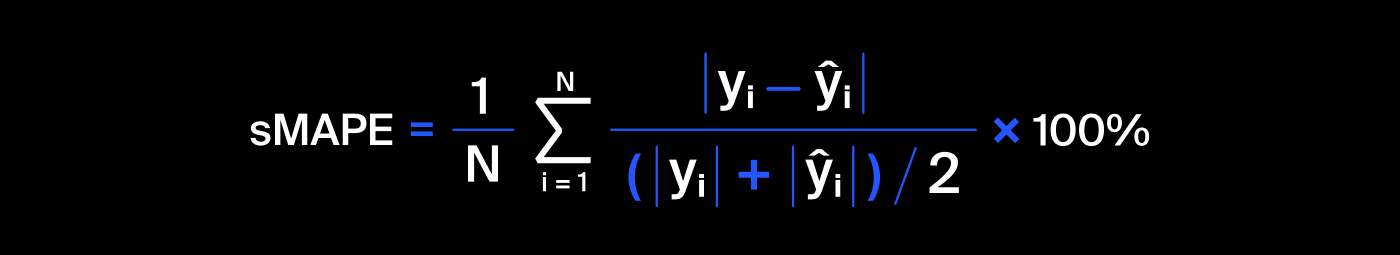

In [32]:
display.Image("https://pictures.s3.yandex.net/resources/smape_1576239058.jpg")

* y_i – значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество
* y_hat_i – значение предсказания для объекта с порядковым номером i, например, в тестовой выборке
* N – количество объектов в выборке
* sum – суммирование по всем объектам выборки (i меняется от 1 до N)

Создадим `scorer_smape` – объект, который позволит включить нашу метрику в GridSearchCV, чтобы она использовалась для подбора параметров и проверки модели на тренировочной выборке.

In [33]:
scorer_smape = make_scorer(smape, greater_is_better=False)

Теперь у нас готовы обучающая выборка и метрика для оценки качества. Далее добавим в тестовый массив данных целевые переменные – `final.output.recovery` и `rougher.output.recovery`. 

In [34]:
df_test = df_test.join(df_full[['date', 'final.output.recovery', 'rougher.output.recovery']].set_index('date'), on='date')
display.display(df_test.head(3))

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,70.273583,89.993421
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,68.910432,88.089657
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,68.143213,88.412756


Проверим, что объединение реализовано корректно: выведем значения переменной `final.output.recovery` в исходном и тестовом массиве за 2016-09-01 00:59:59.

In [35]:
df_full.loc[df_full['date'] == '2016-09-01 00:59:59', 'final.output.recovery'], df_test.loc[df_test['date'] == '2016-09-01 00:59:59', 'final.output.recovery']

(4682    70.273583
 Name: final.output.recovery, dtype: float64,
 0    70.273583
 Name: final.output.recovery, dtype: float64)

Удалим из тестового массива данных пропуски. Не будем их заполнять, чтобы минимизировать влияние на тестовую выборку.

In [36]:
df_test.dropna(inplace=True)

Выберем из обучающей и тестовой выборки признаки и таргеты, присвоим их отдельным переменным. Проверим размерность.

In [37]:
features_train, features_test = df_train.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1), df_test.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
print(features_train.shape, features_test.shape)

target_rougher_train, target_rougher_test = df_train['rougher.output.recovery'], df_test['rougher.output.recovery']
print(target_rougher_train.shape, target_rougher_test.shape)

target_final_train, target_final_test = df_train['final.output.recovery'], df_test['final.output.recovery']
print(target_final_train.shape, target_final_test.shape)

(13795, 52) (5105, 52)
(13795,) (5105,)
(13795,) (5105,)


Далее рассмотрим модель дерева решений, случайного леса и линейной регрессии. Подберем параметры на кросс-валидации (с использованием GridSearchCV).

### Эффективность обогащения чернового концентрата 

#### Решающее дерево

In [38]:
params_tree = {'max_depth': range(20,30,2),
               #'min_samples_leaf': range(1,4),
               'min_samples_split': range(20,30,2)}

folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid_tree = GridSearchCV(DecisionTreeRegressor(random_state=42), params_tree, cv=folds, scoring=scorer_smape)

In [39]:
%%time
grid_tree.fit(features_train, target_rougher_train)

CPU times: user 1min 42s, sys: 579 ms, total: 1min 43s
Wall time: 1min 43s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': range(20, 30, 2),
                         'min_samples_split': range(20, 30, 2)},
             scoring=make_scorer(smape, greater_is_better=False))

In [40]:
print(grid_tree.best_params_)
print(-grid_tree.best_score_)
print(grid_tree.best_estimator_)

{'max_depth': 24, 'min_samples_split': 28}
3.402268341467372
DecisionTreeRegressor(max_depth=24, min_samples_split=28, random_state=42)


Визуализируем полученные предсказания.

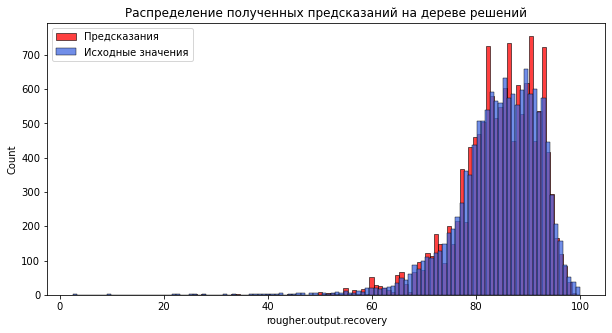

In [43]:
plt.figure(figsize=(10,5))
sns.histplot(x=grid_tree.predict(features_train), color='red', label='Предсказания')
sns.histplot(x=target_rougher_train, color='royalblue', label='Исходные значения')
plt.legend()
plt.title('Распределение полученных предсказаний на дереве решений')
plt.show()

#### Случайный лес

In [44]:
params_forest = {'max_depth': range(20,30,2),
                 #'min_samples_leaf': range(1,4),
                 'n_estimators': range(10,30,10)}

folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid_forest = GridSearchCV(RandomForestRegressor(random_state=42), params_forest, cv=folds, scoring=scorer_smape)

In [45]:
%%time
grid_forest.fit(features_train, target_rougher_train)

CPU times: user 7min 3s, sys: 2.11 s, total: 7min 5s
Wall time: 7min 6s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': range(20, 30, 2),
                         'n_estimators': range(10, 30, 10)},
             scoring=make_scorer(smape, greater_is_better=False))

In [46]:
print(grid_forest.best_params_)
print(-grid_forest.best_score_)
print(grid_forest.best_estimator_)

{'max_depth': 26, 'n_estimators': 20}
2.66879385737892
RandomForestRegressor(max_depth=26, n_estimators=20, random_state=42)


Визуализируем предсказания и исходные значения.

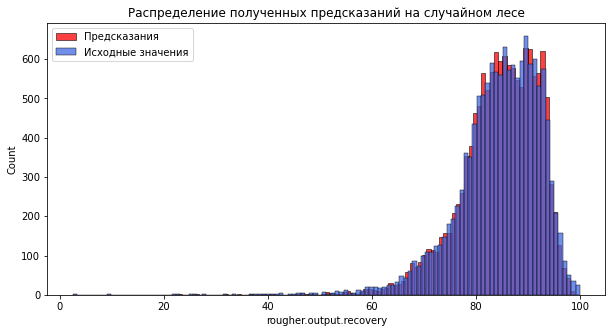

In [47]:
plt.figure(figsize=(10,5))
sns.histplot(x=grid_forest.predict(features_train), color='red', label='Предсказания')
sns.histplot(x=target_rougher_train, color='royalblue', label='Исходные значения')
plt.legend()
plt.title('Распределение полученных предсказаний на случайном лесе')
plt.show()

Оценим важность признаков. Возможно, не все из них нужны для обучения модели. Для этого создадим столбец с "шумом" (рандомными значениями из нормального распределения), обучим случайный лес и визуализируем `feature_importance_` (важность признаков).

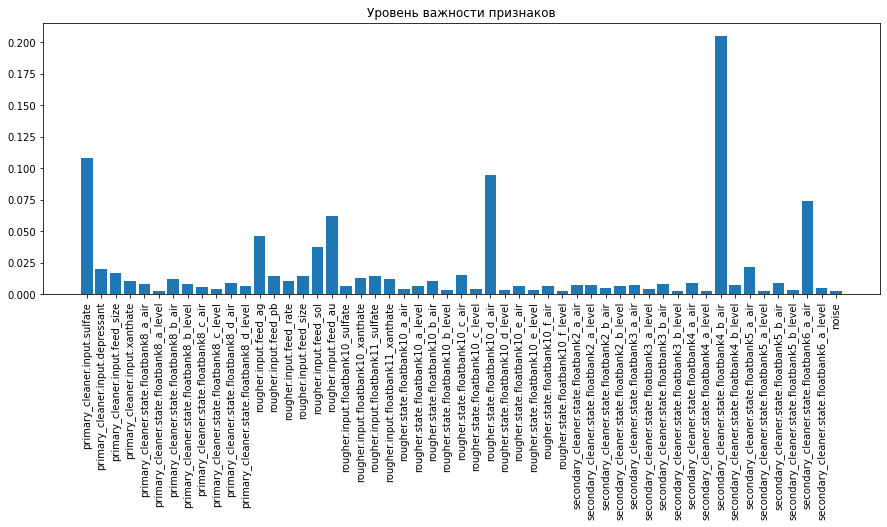

In [49]:
best_feat = features_train.copy()

best_feat["noise"] = np.random.randn(len(best_feat))
feature_importance = grid_forest.best_estimator_.fit(best_feat, target_rougher_train)

plt.figure(figsize=(15,5))
plt.bar(best_feat.columns, feature_importance.feature_importances_)
plt.xticks(rotation = 90)
plt.title('Уровень важности признаков')
plt.show()

**Вывод:** Технически все признаки важнее, чем шум, который мы добавили в массив. Далее выведем самые важные признаки, воспользовавшись `SelectFromModel`.

In [50]:
best_feat = SelectFromModel(grid_forest.best_estimator_)
best_feat.fit(features_train, target_rougher_train)
best_feat.transform(features_train)
features_names = features_train.columns
features_names[best_feat.get_support()]

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'rougher.input.feed_ag', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.state.floatbank10_d_air',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank6_a_air'],
      dtype='object')

**Вывод:** Мы видим, что это те же самые признаки, которые выделяются на графике выше. Далее для обучения будем использовать все признаки, поскольку технически не удалось выделить не важные с точки зрения модели.

#### Линейная регрессия

In [51]:
# используем пайплайн, чтобы скалирование данных трейна было на каждом фолде (но не на валидации)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lin_model', LinearRegression())])

folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
print(np.mean(-cross_val_score(pipe, features_train, target_rougher_train, 
                               cv=folds, scoring=scorer_smape)))

4.665943692678814


In [52]:
pipe.fit(features_train, target_rougher_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lin_model', LinearRegression())])

Визуализируем результат обучения модели.

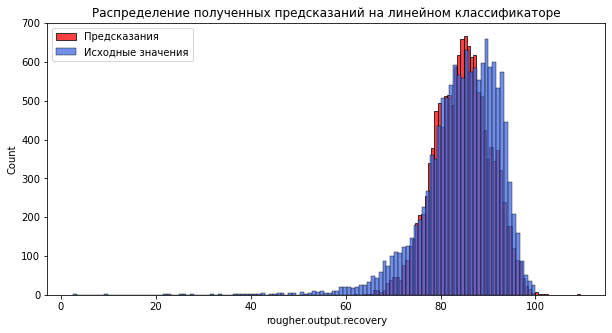

In [53]:
plt.figure(figsize=(10,5))
sns.histplot(x=pipe.predict(features_train), color='red', label='Предсказания')
sns.histplot(x=target_rougher_train, color='royalblue', label='Исходные значения')
plt.legend()
plt.title('Распределение полученных предсказаний на линейном классификаторе')
plt.show()

### Эффективность обогащения финального концентрата 

#### Решающее дерево

In [54]:
params_tree_final = {'max_depth': range(10,30,2),
                     'min_samples_split': range(20,30,2)}

folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid_tree_final = GridSearchCV(DecisionTreeRegressor(random_state=42), params_tree_final, cv=folds, scoring=scorer_smape)

In [55]:
%%time
grid_tree_final.fit(features_train, target_final_train)

CPU times: user 3min 32s, sys: 359 ms, total: 3min 32s
Wall time: 3min 32s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': range(10, 30, 2),
                         'min_samples_split': range(20, 30, 2)},
             scoring=make_scorer(smape, greater_is_better=False))

In [56]:
print(grid_tree_final.best_params_)
print(-grid_tree_final.best_score_)
print(grid_tree_final.best_estimator_)

{'max_depth': 14, 'min_samples_split': 28}
7.263039772045741
DecisionTreeRegressor(max_depth=14, min_samples_split=28, random_state=42)


Визуализируем результат обучения. Можем видеть, насколько сильно ошибается наша модель.

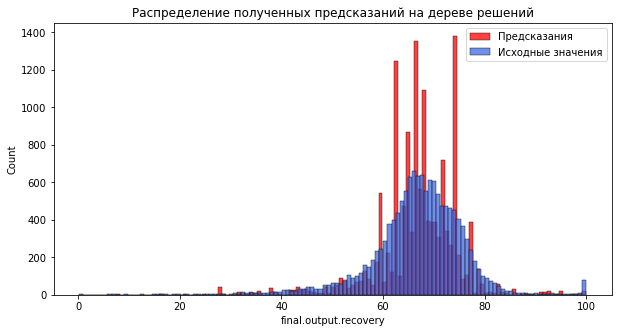

In [57]:
plt.figure(figsize=(10,5))
sns.histplot(x=grid_tree_final.predict(features_train), color='red', label='Предсказания')
sns.histplot(x=target_final_train, color='royalblue', label='Исходные значения')
plt.legend()
plt.title('Распределение полученных предсказаний на дереве решений')
plt.show()

#### Случайный лес

In [58]:
params_forest_final = {'max_depth': range(25,35,2),
                       'n_estimators': range(15,30,5)}

folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
grid_forest_final = GridSearchCV(RandomForestRegressor(random_state=42), params_forest_final, cv=folds, scoring=scorer_smape)

In [59]:
%%time
grid_forest_final.fit(features_train, target_final_train)

CPU times: user 16min 20s, sys: 1.81 s, total: 16min 22s
Wall time: 16min 22s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': range(25, 35, 2),
                         'n_estimators': range(15, 30, 5)},
             scoring=make_scorer(smape, greater_is_better=False))

In [60]:
print(grid_forest_final.best_params_)
print(-grid_forest_final.best_score_)
print(grid_forest_final.best_estimator_)

{'max_depth': 27, 'n_estimators': 25}
5.929331857344046
RandomForestRegressor(max_depth=27, n_estimators=25, random_state=42)


Визуализируем результаты обучения. Наша модель более-менее хорошо справляется.

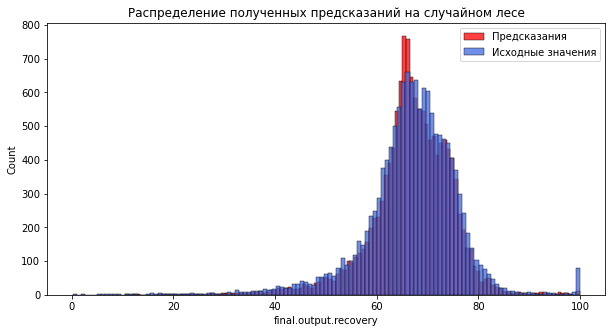

In [61]:
plt.figure(figsize=(10,5))
sns.histplot(x=grid_forest_final.predict(features_train), color='red', label='Предсказания')
sns.histplot(x=target_final_train, color='royalblue', label='Исходные значения')
plt.legend()
plt.title('Распределение полученных предсказаний на случайном лесе')
plt.show()

Также оценим важность признаков для модели случайного леса. Добавим шум (случайный набор чисел из нормального распределения) и сравним его значимость со значимостью признаков в массиве.

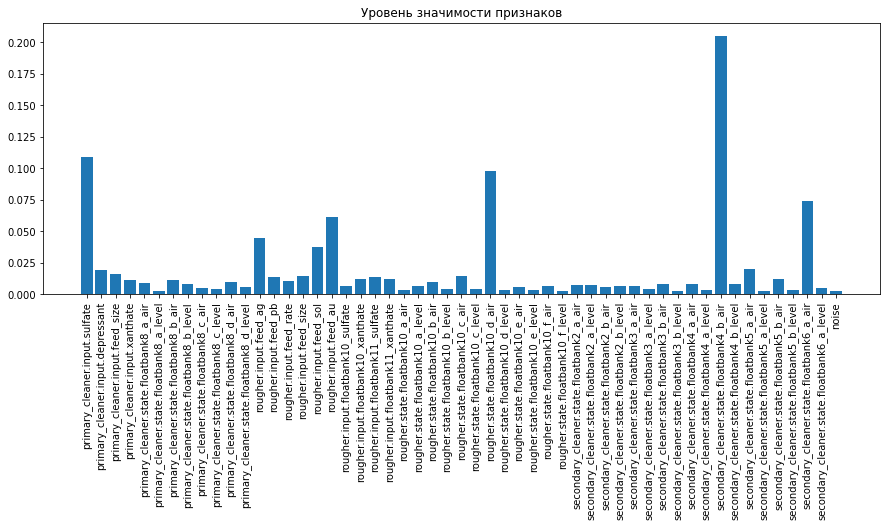

In [62]:
best_feat = features_train.copy()

best_feat["noise"] = np.random.randn(len(best_feat))
feature_importance_final = grid_forest_final.best_estimator_.fit(best_feat, target_rougher_train)

plt.figure(figsize=(15,5))
plt.bar(best_feat.columns, feature_importance_final.feature_importances_)
plt.xticks(rotation = 90)
plt.title('Уровень значимости признаков')
plt.show()

**Вывод:** Модель не определила, что какой-либо признак менее значим для принятия решения, чем шум. Для обучения моделей будем использовать все переменные.

Выведем самые важные для предсказания признаки, предварительно удалив из массива "шум." 

In [63]:
best_feat = SelectFromModel(grid_forest_final.best_estimator_)
best_feat.fit(features_train, target_rougher_train)
best_feat.transform(features_train)
features_names = features_train.columns
features_names[best_feat.get_support()]

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'rougher.input.feed_ag', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.state.floatbank10_d_air',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank6_a_air'],
      dtype='object')

#### Линейная регрессия

In [64]:
pipe_final = Pipeline([('scaler', StandardScaler()),
                       ('lin_model', LinearRegression())])

folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
print(np.mean(-cross_val_score(pipe_final, features_train, target_final_train, 
                               cv=folds, scoring=scorer_smape)))

8.160431865877499


In [65]:
pipe_final.fit(features_train, target_rougher_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lin_model', LinearRegression())])

Визуализируем предсказания. Здесь можно наглядно увидеть, почему нам важно учитывать масштаб как целевого признака, так и предсказания.

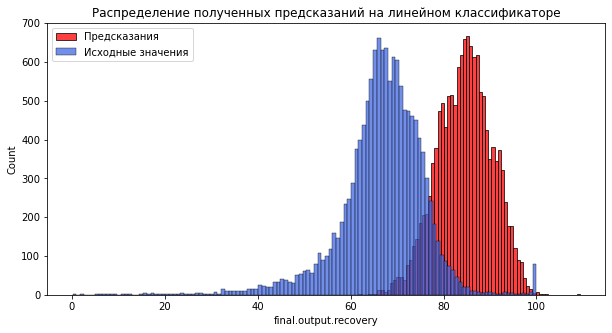

In [66]:
plt.figure(figsize=(10,5))
sns.histplot(x=pipe_final.predict(features_train), color='red', label='Предсказания')
sns.histplot(x=target_final_train, color='royalblue', label='Исходные значения')
plt.legend()
plt.title('Распределение полученных предсказаний на линейном классификаторе')
plt.show()

### Проверка на тесте 

В результате модель случайного леса лучше, чем остальные рассмотренные, справляется как с предсказанием эффективности обогащения чернового концентрата, так и с предсказанием эффективности обогащения финального концентрата.

In [67]:
params_rougher = {'max_depth': 26, 'n_estimators': 20}
forest_rougher = RandomForestRegressor(random_state=42).set_params(**params_rougher)
forest_rougher.fit(features_train, target_rougher_train)

RandomForestRegressor(max_depth=26, n_estimators=20, random_state=42)

In [68]:
rougher_score = smape(np.array(target_rougher_test), forest_rougher.predict(features_test))
print('Оценка предсказания эффективности обогащения чернового концентрата на тестовой выборке:', rougher_score)

Оценка предсказания эффективности обогащения чернового концентрата на тестовой выборке: 4.354202008799191


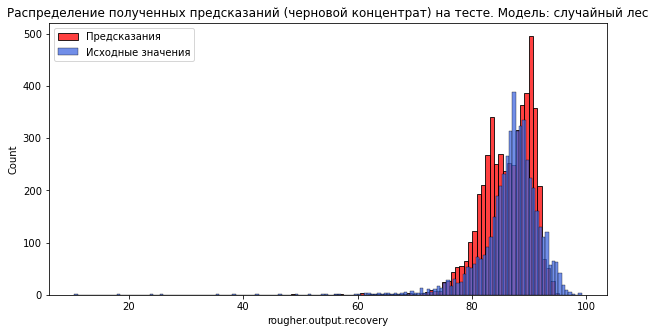

In [69]:
plt.figure(figsize=(10,5))
sns.histplot(x=forest_rougher.predict(features_test), color='red', label='Предсказания')
sns.histplot(x=target_rougher_test, color='royalblue', label='Исходные значения')
plt.legend()
plt.title('Распределение полученных предсказаний (черновой концентрат) на тесте. Модель: случайный лес')
plt.show()

In [70]:
params_final = {'max_depth': 27, 'n_estimators': 25}
forest_final = RandomForestRegressor(random_state=42).set_params(**params_final)
forest_final.fit(features_train, target_final_train)

RandomForestRegressor(max_depth=27, n_estimators=25, random_state=42)

In [71]:
final_concentrate_score = smape(np.array(target_final_test), forest_final.predict(features_test))
print('Оценка предсказания эффективности обогащения финального концентрата на тестовой выборке:', final_concentrate_score)

Оценка предсказания эффективности обогащения финального концентрата на тестовой выборке: 8.173967710377006


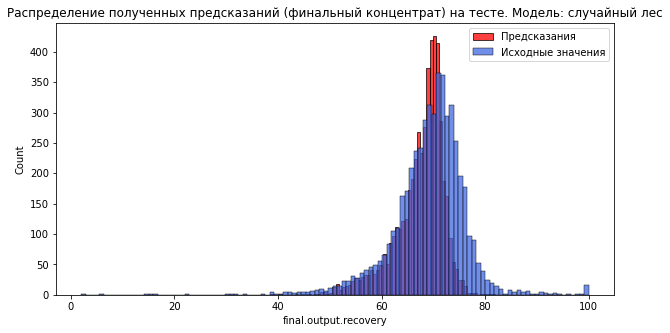

In [72]:
plt.figure(figsize=(10,5))
sns.histplot(x=forest_final.predict(features_test), color='red', label='Предсказания')
sns.histplot(x=target_final_test, color='royalblue', label='Исходные значения')
plt.legend()
plt.title('Распределение полученных предсказаний (финальный концентрат) на тесте. Модель: случайный лес')
plt.show()

Посчитаем итоговую метрику. Для этого фоспользуемся функцией `final_smape`, которая была инициализирована в начале.

In [73]:
final_score = final_smape(rougher_score, final_concentrate_score)
print(final_score)

7.219026284982553


Проверим модель на адекватность с использованием модели DummyRegressor, которая делает предсказания для средних.

In [74]:
dummy_reg = DummyRegressor()
dummy_reg.fit(features_train, target_rougher_train)
dummy_rough = smape(target_rougher_test, dummy_reg.predict(features_test))
print(dummy_rough)

5.297058820770408


In [75]:
dummy_reg_final = DummyRegressor()
dummy_reg_final.fit(features_train, target_final_train)
dummy_final = smape(target_final_test, dummy_reg_final.predict(features_test))
print(dummy_final)

8.463283629208318


In [76]:
final_score = final_smape(dummy_rough, dummy_final)
print(final_score)

7.6717274270988405


**Вывод:** Наша модель справляется лучше, чем константная модель.

## Вывод

В ходе предобратоки мы изучили данные, определили пропуски и заполнили их на обчующей выборке; выявили мультиколлинеарность и определили её природу; убедились, что эффективность обогащения была рассчитана правильно; определили, какие переменные отсутсвуют в тестовой выборке, объяснили причину их отсуствия, удалили их из обучающей выборки. В ходе исследовательского анализа данных мы выявили аномалии, удалили их. 

Далее была выбрана лучшая предсказательная модель, которая позволяет предсказывать эффективность обогащения чернового и финального концентратов – *случайный лес*. Модель лучше предсказывает как эффективность обогащения чернового, так и эффективность обогащения финального концентратов. Качество оценивалось с помощью метрики sMAPE, финальное значение которой для чернового и финального концентрата рассчитывалось в пропорции 25:75 соответственно и составила 7.28. Так, был смоделирован процесс восстановления золота из золотосодержащей руды. 